In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np

In [28]:
import numpy as np
import pandas as pd

In [29]:
import datetime as dt
import seaborn as sns

# Reflect Tables into SQLAlchemy ORM

In [74]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [75]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=True)

In [76]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

2019-04-01 23:19:20,400 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-01 23:19:20,400 INFO sqlalchemy.engine.base.Engine ()
2019-04-01 23:19:20,400 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-01 23:19:20,400 INFO sqlalchemy.engine.base.Engine ()
2019-04-01 23:19:20,400 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-01 23:19:20,400 INFO sqlalchemy.engine.base.Engine ()
2019-04-01 23:19:20,400 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("measurement")
2019-04-01 23:19:20,400 INFO sqlalchemy.engine.base.Engine ()
2019-04-01 23:19:20,415 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'measurement' AND type = 'table'
2019-04-01 23:19:20,415 INFO sqlalchemy.engine.base.Engine ()
2019-04-01 23:19:20,415 INFO sqlalchemy.

In [77]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [78]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [79]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [80]:
#inspecting columns
inspector = inspect(engine)
[i['name'] for i in inspector.get_columns('measurement')]

2019-04-01 23:19:29,110 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("measurement")
2019-04-01 23:19:29,110 INFO sqlalchemy.engine.base.Engine ()


['id', 'station', 'date', 'prcp', 'tobs']

In [81]:
# Design a query to retrieve the last 12 months of precipitation data and plot the result
climate_data=session.query(Measurement.date,Measurement.station,Measurement.prcp).order_by(Measurement.date.desc()).all()
#Filtering out rows with no observation
climate_data=[i for i in climate_data if i[2]!=None]
#Converting date to a recognization format
meas_day=[dt.datetime.strptime(i[0],'%Y-%m-%d').date() for i in climate_data]
#generating list of stations
meas_station=[i[1] for i in climate_data]
#generating list of precipitation observed
meas_prcp=[i[2] for i in climate_data]
#creating dataframe from lists above
climate_df=pd.DataFrame({'Date':meas_day,'Station':meas_station,'Precipitation':meas_prcp})
#identifying indices where observation date is within the last 12 months
last12months=[i.days<365 for i in (climate_df['Date'].max()-climate_df['Date'])]
#slicing data frame to last 12 months
climate_df=climate_df.loc[last12months,:]
#sorting dataframe by ascending date
climate_df=climate_df.sort_values('Date')


2019-04-01 23:19:39,815 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2019-04-01 23:19:39,815 INFO sqlalchemy.engine.base.Engine SELECT measurement.date AS measurement_date, measurement.station AS measurement_station, measurement.prcp AS measurement_prcp 
FROM measurement ORDER BY measurement.date DESC
2019-04-01 23:19:39,815 INFO sqlalchemy.engine.base.Engine ()


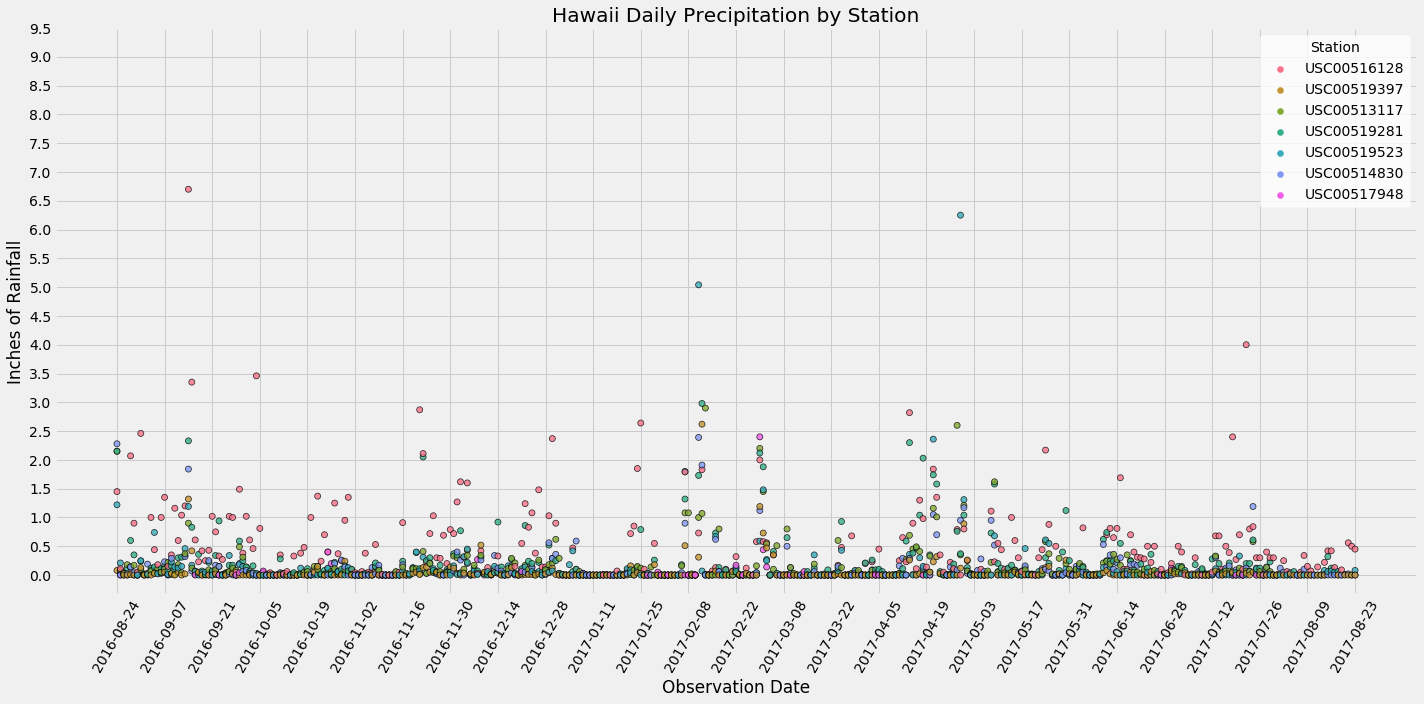

In [82]:
#generating x_axis series
x_axis=[str(i) for i in climate_df['Date']]
#generating y_axis sereis
y_axis=[i for i in climate_df['Precipitation']]
#generating station id series
sta=[i for i in climate_df['Station']]
#creating plot object with specific size
fig=plt.figure(figsize=(20,10))
#using seaborn function to plot
sns.scatterplot(x=x_axis,y=y_axis,hue=sta,alpha=.8,edgecolor='black')
#specifying the indices of x,y ticks to show, at a rotation angle
plt.xticks(np.arange(0, 365, step=14), rotation=60)
plt.yticks(np.arange(0, 10, step=.5))
#legend & positioning
plt.legend(loc='best',title="Station",edgecolor='w',facecolor='w')
#plot title
plt.title('Hawaii Daily Precipitation by Station')
#plot x-axis title
plt.xlabel('Observation Date')
#plot y-axis title
plt.ylabel('Inches of Rainfall')
#ensures whole plot is saved
plt.tight_layout()
#saving figure
plt.savefig('./All_Station_Precipitation.png', dpi=fig.dpi,facecolor='w',edgecolor='w')
#display figure
plt.show()

In [83]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [84]:
# Design a query to show how many stations are available in this dataset?
station_list=session.query(Measurement.station).distinct().all()
len(station_list)

2019-04-01 23:19:45,640 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT measurement.station AS measurement_station 
FROM measurement
2019-04-01 23:19:45,640 INFO sqlalchemy.engine.base.Engine ()


9

In [85]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity=session.query(Measurement.station,func.count(Measurement.prcp)).\
group_by(Measurement.station).\
filter(Measurement.prcp!=None).order_by(func.count(Measurement.prcp).desc()).all()
station_activity

2019-04-01 23:19:47,351 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station, count(measurement.prcp) AS count_1 
FROM measurement 
WHERE measurement.prcp IS NOT NULL GROUP BY measurement.station ORDER BY count(measurement.prcp) DESC
2019-04-01 23:19:47,366 INFO sqlalchemy.engine.base.Engine ()


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [86]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active=session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station==station_activity[0][0]).all()
most_active

2019-04-01 23:19:48,217 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station, min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, avg(measurement.tobs) AS avg_1 
FROM measurement 
WHERE measurement.station = ?
2019-04-01 23:19:48,217 INFO sqlalchemy.engine.base.Engine ('USC00519281',)


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [87]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_temp=session.query(Measurement.station,func.count(Measurement.tobs),func.max(Measurement.date)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()
last12min=str(dt.datetime.strptime(most_active_temp[2],'%Y-%m-%d').date()+dt.timedelta(-365))
last12temp=session.query(Measurement.date,Measurement.tobs).filter(Measurement.date>last12min).\
filter(Measurement.station==most_active_temp[0]).all()

2019-04-01 23:19:49,033 INFO sqlalchemy.engine.base.Engine SELECT measurement.station AS measurement_station, count(measurement.tobs) AS count_1, max(measurement.date) AS max_1 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.tobs) DESC
 LIMIT ? OFFSET ?
2019-04-01 23:19:49,033 INFO sqlalchemy.engine.base.Engine (1, 0)
2019-04-01 23:19:49,048 INFO sqlalchemy.engine.base.Engine SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date > ? AND measurement.station = ?
2019-04-01 23:19:49,048 INFO sqlalchemy.engine.base.Engine ('2016-08-18', 'USC00519281')


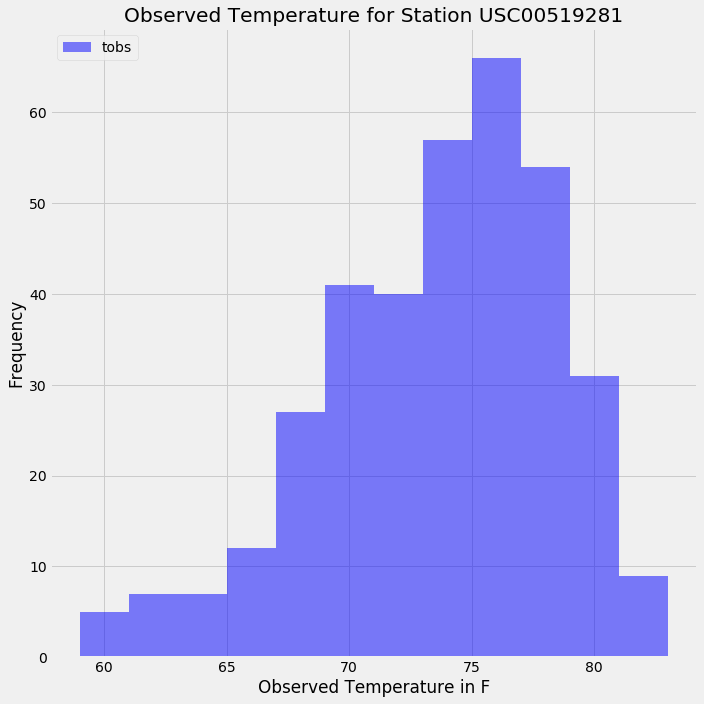

In [88]:
tobs=[i[1] for i in last12temp]
fig=plt.figure(figsize=(10,10))
plt.hist(x=tobs, bins=12, facecolor='blue', alpha=0.5)
plt.legend(labels=['tobs'],loc='upper left')
plt.xlabel('Observed Temperature in F')
plt.ylabel('Frequency')
plt.title(f'Observed Temperature for Station {most_active_temp[0]}')
plt.tight_layout()
#saving figure
plt.savefig('./Most_Active_Station_Temperature_Histogram.png', dpi=fig.dpi,facecolor='w',edgecolor='w')
#display figure
plt.show()

![precipitation](Images/station-histogram.png)

In [89]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

2019-04-01 23:19:53,647 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2019-04-01 23:19:53,647 INFO sqlalchemy.engine.base.Engine ('2012-02-28', '2012-03-05')
[(62.0, 69.57142857142857, 74.0)]


In [90]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start='2019-06-23'
trip_end='2019-07-10'
trip_start_last_12=dt.date(2017,int(trip_start[5:7]),int(trip_start[8:10]))
trip_end_last_12=dt.date(2017,int(trip_end[5:7]),int(trip_end[8:10]))
print(calc_temps(trip_start_last_12,trip_end_last_12))

2019-04-01 23:19:58,551 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2019-04-01 23:19:58,551 INFO sqlalchemy.engine.base.Engine ('2017-06-23', '2017-07-10')
[(69.0, 77.66055045871559, 87.0)]


In [91]:
trip_temp=calc_temps(trip_start_last_12,trip_end_last_12)
trip_temp

2019-04-01 23:19:59,199 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2019-04-01 23:19:59,199 INFO sqlalchemy.engine.base.Engine ('2017-06-23', '2017-07-10')


[(69.0, 77.66055045871559, 87.0)]

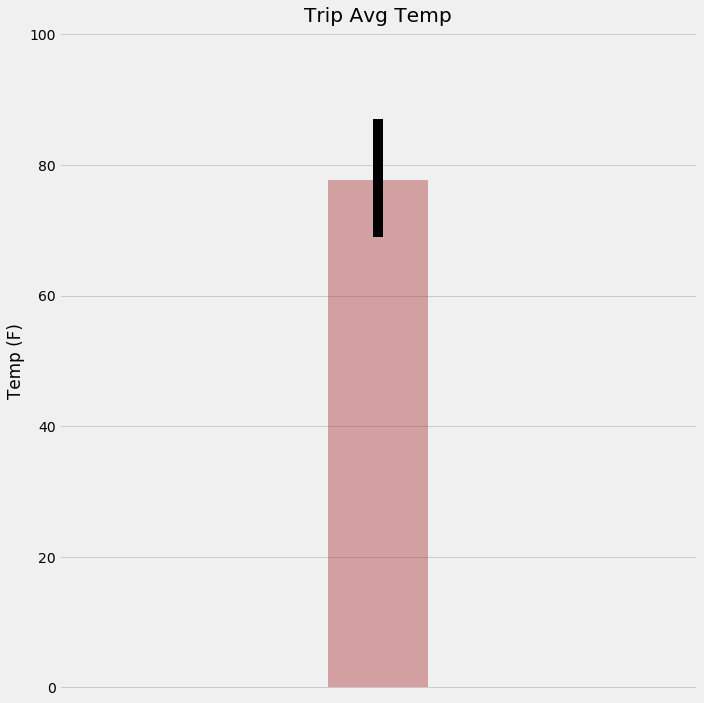

In [92]:
fig=plt.figure(figsize=(10,10))
plt.plot([1,1],[0,trip_temp[0][1]],linewidth=100,c='brown',alpha=.4)
plt.plot([1,1],[trip_temp[0][0],trip_temp[0][2]],linewidth=10,c='black')
plt.xticks([])
plt.ylim(-1,101)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
#saving figure
plt.savefig('./Trip_Temperature.png', dpi=fig.dpi,facecolor='w',edgecolor='w')
#display figure
plt.show()

In [113]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_station=session.query(Measurement.date,Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.prcp).filter(Measurement.station==Station.station).\
filter(Measurement.date>=trip_start_last_12).filter(Measurement.date<=trip_end_last_12).\
order_by(Measurement.prcp.desc()).all()
[i for i in rainfall_station]

2019-04-01 23:48:11,131 INFO sqlalchemy.engine.base.Engine SELECT measurement.date AS measurement_date, station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation, measurement.prcp AS measurement_prcp 
FROM measurement, station 
WHERE measurement.station = station.station AND measurement.date >= ? AND measurement.date <= ? ORDER BY measurement.prcp DESC
2019-04-01 23:48:11,131 INFO sqlalchemy.engine.base.Engine ('2017-06-23', '2017-07-10')


[('2017-06-23',
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.5),
 ('2017-06-25',
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.5),
 ('2017-07-02',
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.5),
 ('2017-07-03',
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.4),
 ('2017-06-24',
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.36),
 ('2017-07-07',
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.3),
 ('2017-06-24',
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.22),
 ('2017-06-30',
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.2),
 ('2017-07-07',
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.18),
 ('2017-07-02',
  'USC0

## Optional Challenge Assignment

In [144]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

2019-04-02 00:08:19,273 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
2019-04-02 00:08:19,273 INFO sqlalchemy.engine.base.Engine ('%m-%d', '01-01')


[(62.0, 69.15384615384616, 77.0)]

In [154]:
duration=(dt.datetime.strptime(trip_end,'%Y-%m-%d').date()-dt.datetime.strptime(trip_start,'%Y-%m-%d').date()).days
trip_dates=[str(dt.datetime.strptime(trip_start,'%Y-%m-%d').date()+dt.timedelta(i))[5:12] for i in range(duration+1)]
trip_normals=[daily_normals(i)[0] for i in trip_dates]
trip_normals

2019-04-02 00:14:39,114 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
2019-04-02 00:14:39,114 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-23')
2019-04-02 00:14:39,114 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
2019-04-02 00:14:39,114 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-24')
2019-04-02 00:14:39,130 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
2019-04-02 00:14:39,130 INFO sqlalchemy.engine.base.Engine ('%m-%d', '06-25')
2019-04-02 00:14:39,146 INFO sqlalchemy.engine.base.Engine SELECT min(measurement.tobs) AS min_1, avg(meas

[(68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0),
 (67.0, 75.59615384615384, 81.0),
 (67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0)]

In [165]:
date,tmin,tavg,tmax =[str(dt.datetime.strptime(trip_start,'%Y-%m-%d').date()+dt.timedelta(i)) for i in range(duration+1)],[i[0] for i in trip_normals],[i[1] for i in trip_normals],[i[2] for i in trip_normals]

In [169]:
trip_weather=pd.DataFrame({'date':date,'tmin':tmin,'tavg':tavg,'tmax':tmax})
trip_weather=trip_weather.set_index('date')
trip_weather

,tmin,tavg,tmax
date,,,
2019-06-23,68.0,74.543860,80.0
2019-06-24,68.0,74.964286,84.0
2019-06-25,68.0,74.103448,80.0
2019-06-26,67.0,74.214286,82.0
2019-06-27,66.0,75.017857,81.0
2019-06-28,69.0,74.886792,80.0
2019-06-29,67.0,74.915254,80.0
2019-06-30,67.0,75.596154,81.0
2019-07-01,67.0,74.777778,81.0


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


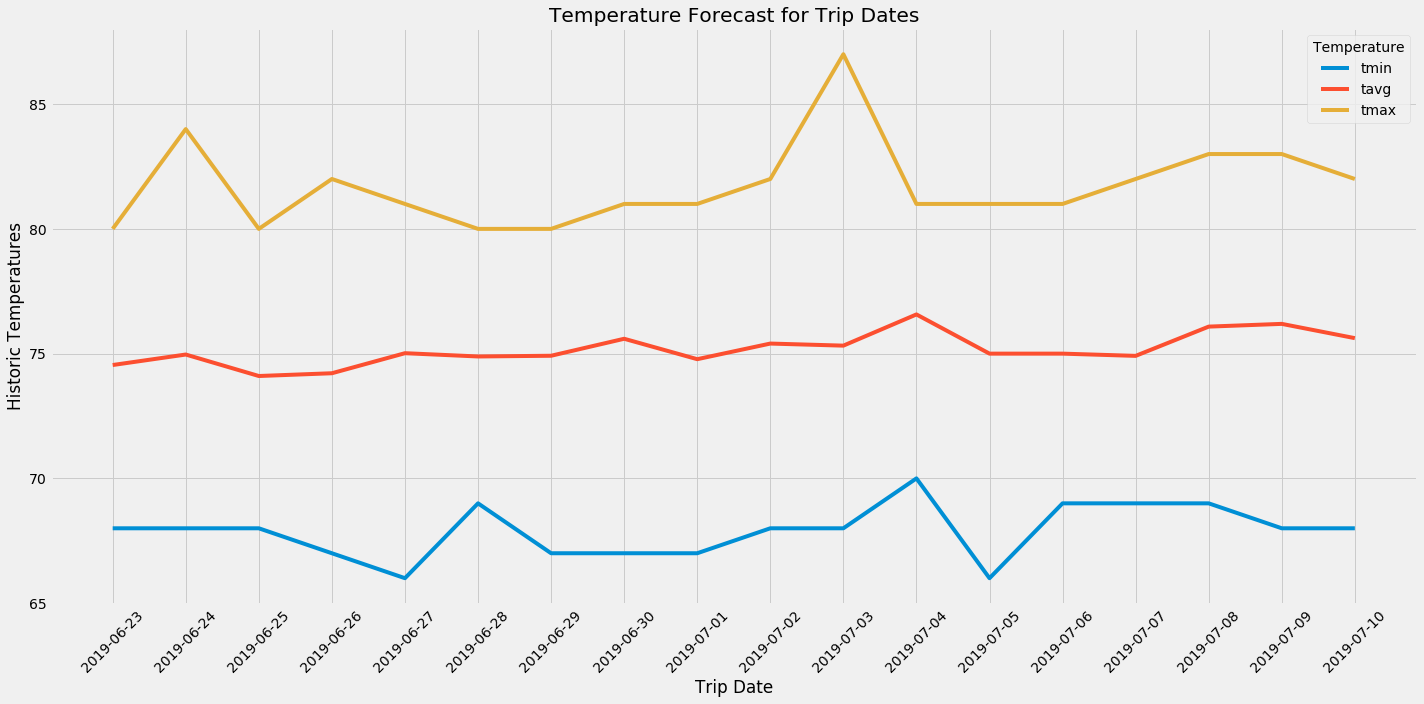

In [198]:
# Plot the daily normals as an area plot with `stacked=False`
fig=plt.figure(figsize=(20,10))
plt.plot(trip_weather.index,trip_weather['tmin'])
plt.plot(trip_weather.index,trip_weather['tavg'])
plt.plot(trip_weather.index,trip_weather['tmax'])
plt.xticks(rotation=45)
plt.xlabel('Trip Date')
plt.ylabel('Historic Temperatures')
plt.title('Temperature Forecast for Trip Dates')
plt.legend(loc='best',title="Temperature")
plt.tight_layout()
plt.savefig('./Trip_Temp_Forecast.png', dpi=fig.dpi,facecolor='w',edgecolor='w')
#display figure
plt.show()